Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [X] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [56]:
import pandas as pd

import numpy as np

from scipy.stats import randint, uniform
import random as ran

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import f_classif, chi2, SelectKBest, SelectPercentile, SelectFpr, SelectFromModel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

import category_encoders as ce

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')

In [57]:
df = pd.read_csv("vgcSun_hot.csv")

In [58]:
dfTe=pd.concat([df[:903],df[3615:4518]])
dfTr=pd.concat([df[904:3614],df[4519:9034]])

In [60]:
target = "winner"
features = df.columns.drop("winner")

In [61]:
numeric_features = features[788:]
categorical_features = features[1:788]

In [82]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a group of columns based on a list.
    """
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.cols]

In [163]:
# Feature Selection Pipelines
numPipe = Pipeline( [
    ("ncol", ColumnSelector(numeric_features)),
    ("nkbe", SelectKBest(score_func=f_classif, k=90))
    ] )

catPipe = Pipeline( [
    ("ccol", ColumnSelector(categorical_features)),
    ("ckbe", SelectKBest(score_func=chi2, k=69))
    ] )

feats = FeatureUnion([('nums', numPipe), ('cats', catPipe)])

In [164]:
XGB = Pipeline([
      ("feats", feats),
      ("XGBoost",
        XGBClassifier(
            n_estimators = 300,
            max_depth=7,
            learning_rate=.5,
            n_jobs=-1
        ))
  ])

Ran = Pipeline([
      ("feats", feats),
      ("Rand", RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features = 0.97))
  ])

In [76]:
XGB.fit(dfTr[features], dfTr[target])

Pipeline(memory=None,
         steps=[('feats',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('nums',
                                                 Pipeline(memory=None,
                                                          steps=[('ncol',
                                                                  ColumnSelector(cols=Index(['team1_Nones', 'team1_Normals', 'team1_Fightings', 'team1_Flyings',
       'team1_Poisons', 'team1_Grounds', 'team1_Rocks', 'team1_Bugs',
       'team1_Ghosts', 'team1_Steels',
       ...
       'def_min_1', 'spa_min_1', 'spd_min_1', 'spe_mi...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.5,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=None,
                          

In [78]:
XGB.score(dfTe[features], dfTe[target])

0.5869324473975637

In [79]:
param_distributions = {
    # 'feat__nums__nimp__strategy' : ['mean', 'median'],
    'feats__nums__nkbe__k' : randint(1, len(numeric_features)),
    #'feat__nums__nkbe__score_func',
    'feats__cats__ckbe__k' : randint(1, len(categorical_features)),
    #'feat__cats__ckbe__score_func',
    # 'RF__max_depth': [5, 10, 15, 20, None],
    # 'Rand__max_features':uniform(0, 1),
    #'RF__max_leaf_nodes',
    #'RF__min_samples_leaf',
    #'RF__min_samples_split',
    # 'RF__n_estimators':randint(50, 500)
}

search = RandomizedSearchCV(
    Ran, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(df[features], df[target]);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20

In [80]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Best hyperparameters {'feats__cats__ckbe__k': 68, 'feats__nums__nkbe__k': 90}
Cross-validation Accuracy 0.599402258135931


In [165]:
scores = cross_val_score(Ran, df[features], df[target], cv=5, scoring='accuracy')
print(f'Accuracy for 5 folds:', scores.mean())

Accuracy for 5 folds: 0.5920941992767472


In [166]:
Ran.fit(dfTr[features], dfTr[target])
Ran.score(dfTe[features], dfTe[target])

0.5830564784053156

In [203]:
permuter = PermutationImportance(
    Ran,
    scoring='accuracy',
    n_iter=2
)
permuter.fit(dfTe[dfTe.columns.drop(target)], dfTe[target])

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('feats',
                                                 FeatureUnion(n_jobs=None,
                                                              transformer_list=[('nums',
                                                                                 Pipeline(memory=None,
                                                                                          steps=[('ncol',
                                                                                                  ColumnSelector(cols=Index(['team1_Nones', 'team1_Normals', 'team1_Fightings', 'team1_Flyings',
       'team1_Poisons', 'team1_Grounds', 'team1_Rocks', 'team1_Bugs',
       'team1_Ghosts', 'team1_Steels',
       .....
                                                                        criterion='gini',
                                                                        max

In [204]:
eli5.show_weights(permuter, top=None, feature_names=list(dfTe.columns.drop(target)))

Weight,Feature
0.0091 ± 0.0083,team1_mean_typedef
0.0086 ± 0.0116,team1_spe_std
0.0080 ± 0.0006,team2_spa_std
0.0075 ± 0.0105,team1_spa_mean
0.0066 ± 0.0044,team1_hp_mean
0.0064 ± 0.0017,def_min_1
0.0061 ± 0.0122,team2_mean_typedef
0.0058 ± 0.0028,team2_Flying_typedef
0.0050 ± 0.0100,team2_Ice_typedef
0.0047 ± 0.0039,team2_Electric_typedef


In [175]:
from pdpbox.pdp import pdp_isolate, pdp_plot

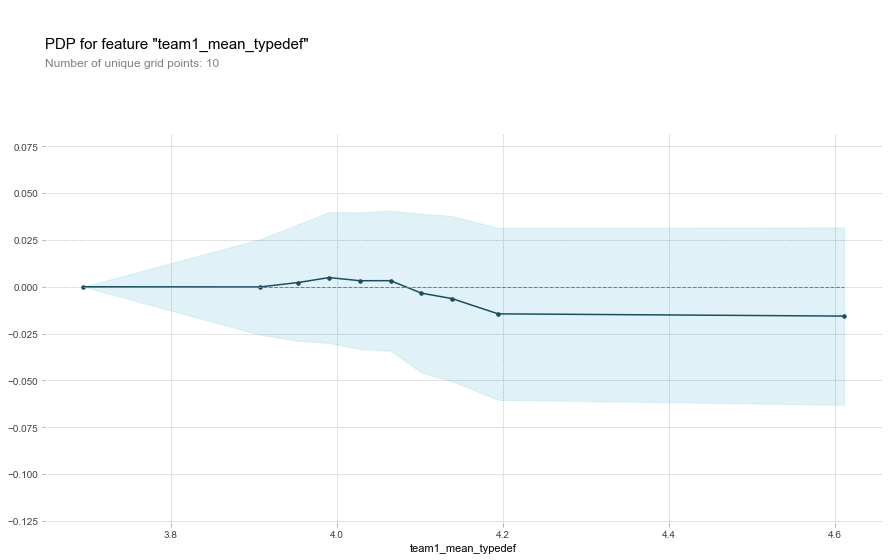

In [205]:
feature = 'team1_mean_typedef'
isolated = pdp_isolate(model=Ran, dataset=dfTe, model_features=dfTe.columns, feature=feature)
pdp_plot(isolated, feature_name=feature);

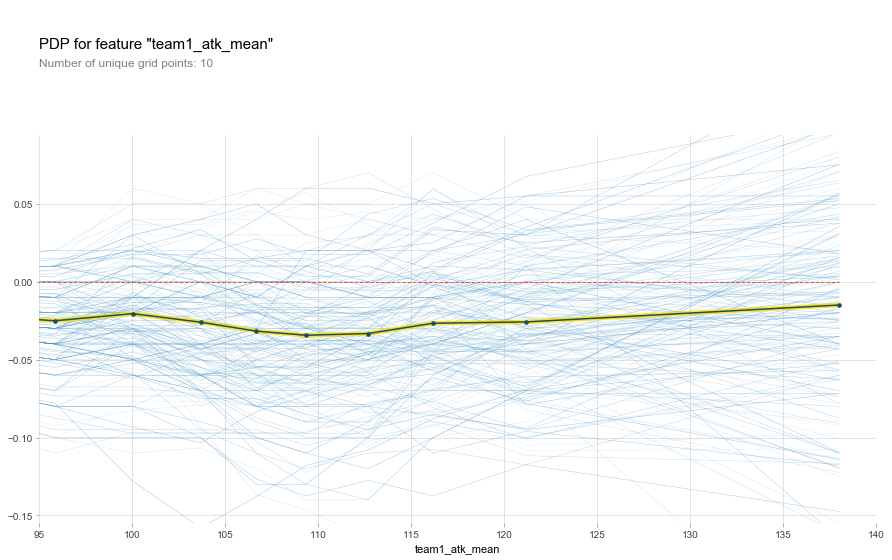

In [193]:
feature = 'team1_atk_mean'
isolated = pdp_isolate(model=Ran, dataset=dfTe, model_features=dfTe.columns, feature=feature)
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=.1);
plt.xlim(95, 140);

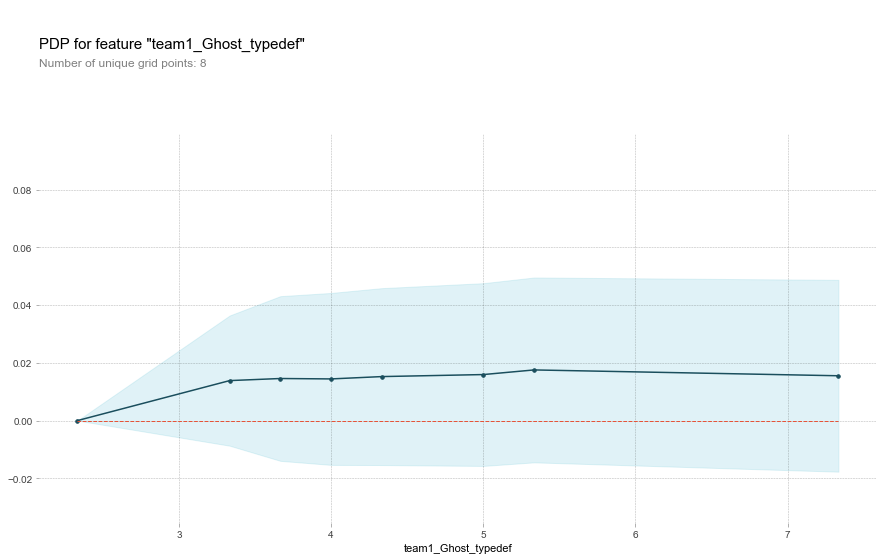

In [181]:
feature = 'team1_Ghost_typedef'
isolated = pdp_isolate(model=Ran, dataset=dfTe, model_features=dfTe.columns, feature=feature)
pdp_plot(isolated, feature_name=feature);

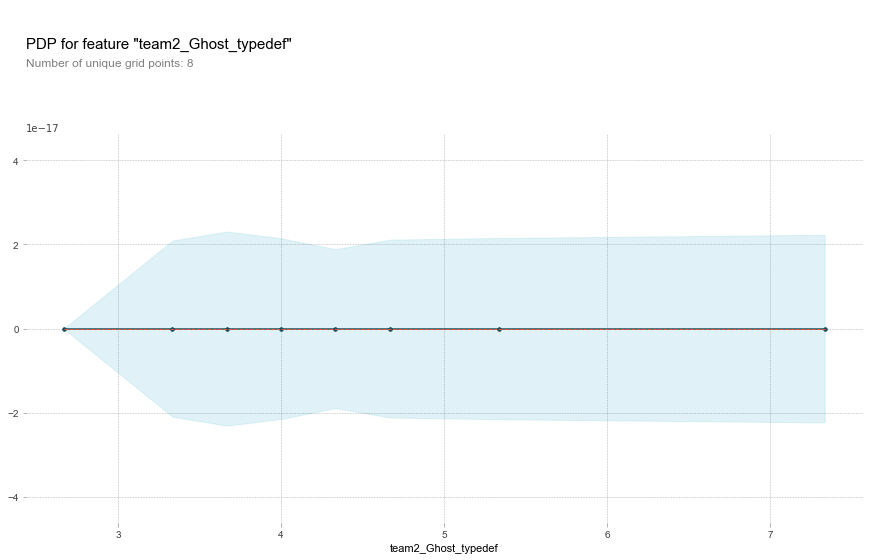

In [185]:
feature = 'team2_Ghost_typedef'
isolated = pdp_isolate(model=Ran, dataset=dfTe, model_features=dfTe.columns, feature=feature)
pdp_plot(isolated, feature_name=feature);

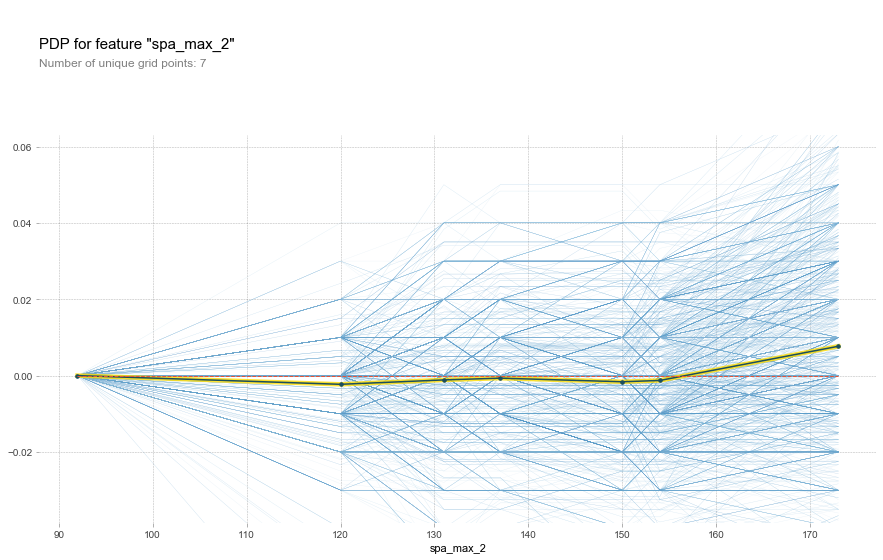

In [196]:
feature = 'spa_max_2'
isolated = pdp_isolate(model=Ran, dataset=dfTe, model_features=dfTe.columns, feature=feature, num_grid_points=20)
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=1);

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c60f9df8c8>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c60fa5c108>})

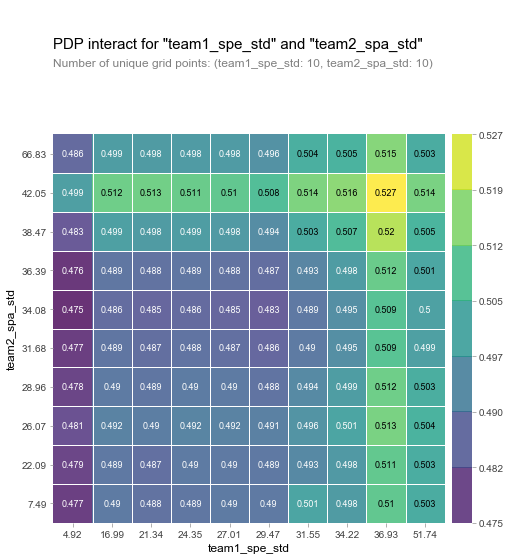

In [206]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['team1_spe_std', 'team2_spa_std']

interaction = pdp_interact(
    model=Ran,
    dataset = df,
    model_features = df.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)